<a href="https://colab.research.google.com/github/dmjLN1026/Pr-dction-TEY/blob/main/Pr%C3%A9diction_TEY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DENG Mingjie and URREGO Oscar

##Dataset: Gas Turbine CO and NOx Emission Data Set
Dataset original source url: https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set

Dataset description: The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by means of average or sum) from a gas turbine located in Turkey's north western region for the purpose of studying flue gas emissions, namely CO and NOx (NO + NO2). The dataset can be well used for predicting turbine energy yield (TEY) using ambient variables as features.

Project aims: Predict turbine energy yield (TEY) with ML.


###Collecting ucimlrepo



In [1]:
pip install ucimlrepo

# 1. Libraries import

In [2]:
# Data handling and numerical operations
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models, preprocessing and tuning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.ensemble import IsolationForest

# XGBoost (additional machine learning model)
import xgboost as xgb

# Utility and fetch functions
import math
from ucimlrepo import fetch_ucirepo
import time

# Suppress all warnings
import warnings
warnings.filterwarnings("ignore")

# 2. Get dataset


##2.1. As recomended by the dataset owner

In [3]:
# fetch dataset
gas_turbine_co_and_nox_emission_data_set = fetch_ucirepo(id=551)

# data (as pandas dataframes)
X = gas_turbine_co_and_nox_emission_data_set.data.features
y = gas_turbine_co_and_nox_emission_data_set.data.targets

# metadata
print(gas_turbine_co_and_nox_emission_data_set.metadata)

# variable information
print(gas_turbine_co_and_nox_emission_data_set.variables)


{'uci_id': 551, 'name': 'Gas Turbine CO and NOx Emission Data Set', 'repository_url': 'https://archive.ics.uci.edu/dataset/551/gas+turbine+co+and+nox+emission+data+set', 'data_url': 'https://archive.ics.uci.edu/static/public/551/data.csv', 'abstract': 'The dataset contains 36733 instances of 11 sensor measures aggregated over one hour, from a gas turbine located in Turkey for the purpose of studying flue gas emissions, namely CO and NOx.', 'area': 'Computer Science', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 36733, 'num_features': 12, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Fri Mar 29 2024', 'dataset_doi': '10.24432/C5WC95', 'creators': [], 'intro_paper': None, 'additional_info': {'summary': "The dataset contains 36733 instances of 11 sensor measures aggregated over one hour (by mea

##2.2. Using simply pandas

In [4]:
df = pd.read_csv('https://archive.ics.uci.edu/static/public/551/data.csv')

data_exp = df.copy().drop('year', axis=1)
#time1=0.00010061264038085938 + 1.6870999336242676 with fetch
#time2=0.0017719268798828125 + 0.6281914710998535 with pandas only

We performed time measurements to check which of the 2 ways of calling the data was more eficient. We noticed that using just the pandas' read_csv method the time spent was shorter so we chose that instance to continue with the treatment of the data

Following the protocol mentioned in the paper (using the first three years' data for training/ cross-validation and the last two for testing) for reproducibility and comparability of works:

#3. Data Exploration

##3.1. Data info

In [5]:
df.info()  # Check data types & nulls.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36733 entries, 0 to 36732
Data columns (total 12 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   year    36733 non-null  int64  
 1   AT      36733 non-null  float64
 2   AP      36733 non-null  float64
 3   AH      36733 non-null  float64
 4   AFDP    36733 non-null  float64
 5   GTEP    36733 non-null  float64
 6   TIT     36733 non-null  float64
 7   TAT     36733 non-null  float64
 8   TEY     36733 non-null  float64
 9   CDP     36733 non-null  float64
 10  CO      36733 non-null  float64
 11  NOX     36733 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 3.4 MB


In [6]:
df.head()  # Display first 5 rows.

,year,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,2011,4.5878,1018.7,83.675,3.5758,23.979,1086.2,549.83,134.67,11.898,0.32663,81.952
1,2011,4.2932,1018.3,84.235,3.5709,23.951,1086.1,550.05,134.67,11.892,0.44784,82.377
2,2011,3.9045,1018.4,84.858,3.5828,23.990,1086.5,550.19,135.10,12.042,0.45144,83.776
3,2011,3.7436,1018.3,85.434,3.5808,23.911,1086.5,550.17,135.03,11.990,0.23107,82.505
4,2011,3.7516,1017.8,85.182,3.5781,23.917,1085.9,550.00,134.67,11.910,0.26747,82.028


In [7]:
# Check for missing values
missing_values = df.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")

Missing values in each column:
year    0
AT      0
AP      0
AH      0
AFDP    0
GTEP    0
TIT     0
TAT     0
TEY     0
CDP     0
CO      0
NOX     0
dtype: int64


In [8]:
df.describe()  # Show descriptive statistics.

,year,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
count,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000,36733.000000
mean,2012.985735,17.712726,1013.070165,77.867015,3.925518,25.563801,1081.428084,546.158517,133.506404,12.060525,2.372468,65.293067
std,1.418965,7.447451,6.463346,14.461355,0.773936,4.195957,17.536373,6.842360,15.618634,1.088795,2.262672,11.678357
min,2011.000000,-6.234800,985.850000,24.085000,2.087400,17.698000,1000.800000,511.040000,100.020000,9.851800,0.000388,25.905000
25%,2012.000000,11.781000,1008.800000,68.188000,3.355600,23.129000,1071.800000,544.720000,124.450000,11.435000,1.182400,57.162000
50%,2013.000000,17.801000,1012.600000,80.470000,3.937700,25.104000,1085.900000,549.880000,133.730000,11.965000,1.713500,63.849000
75%,2014.000000,23.665000,1017.000000,89.376000,4.376900,29.061000,1097.000000,550.040000,144.080000,12.855000,2.842900,71.548000
max,2015.000000,37.103000,1036.600000,100.200000,7.610600,40.716000,1100.900000,550.610000,179.500000,15.159000,44.103000,119.910000


In [9]:
#Tabulating the dataset
from tabulate import tabulate

table = [['Name', 'Description', 'Units'],
        ['AT', 'Ambient Temperature','Celsius'],
        ['AP', 'Ambient Pressure','mbar'],
        ['AH', 'Ambient Humidity', '%'],
        ['AFDP', 'Air Filter Difference Pressure', 'mbar'],
        ['GTEP', 'Gas Turbine Exhaust Pressure', 'mbar'],
        ['TIT', 'Turbine Inlet temperature', 'Celsius'],
        ['TAT', 'Turbine After temperature', 'Celsius'],
        ['TEY', 'Turbine Energy Yield', 'Megawatt hour (MWH)'],
        ['CDP', 'Compressor Discharge Pressure', 'mbar'],
        ['CO', 'Carbon monoxide content','mg/m3'],
        ['NOX', 'Nitrogen oxides content', 'mg/mg3']]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒════════╤════════════════════════════════╤═════════════════════╕
│ Name   │ Description                    │ Units               │
╞════════╪════════════════════════════════╪═════════════════════╡
│ AT     │ Ambient Temperature            │ Celsius             │
├────────┼────────────────────────────────┼─────────────────────┤
│ AP     │ Ambient Pressure               │ mbar                │
├────────┼────────────────────────────────┼─────────────────────┤
│ AH     │ Ambient Humidity               │ %                   │
├────────┼────────────────────────────────┼─────────────────────┤
│ AFDP   │ Air Filter Difference Pressure │ mbar                │
├────────┼────────────────────────────────┼─────────────────────┤
│ GTEP   │ Gas Turbine Exhaust Pressure   │ mbar                │
├────────┼────────────────────────────────┼─────────────────────┤
│ TIT    │ Turbine Inlet temperature      │ Celsius             │
├────────┼────────────────────────────────┼─────────────────────┤
│ TAT    │

##3.2. Histograms

<Figure size 2000x1500 with 0 Axes>

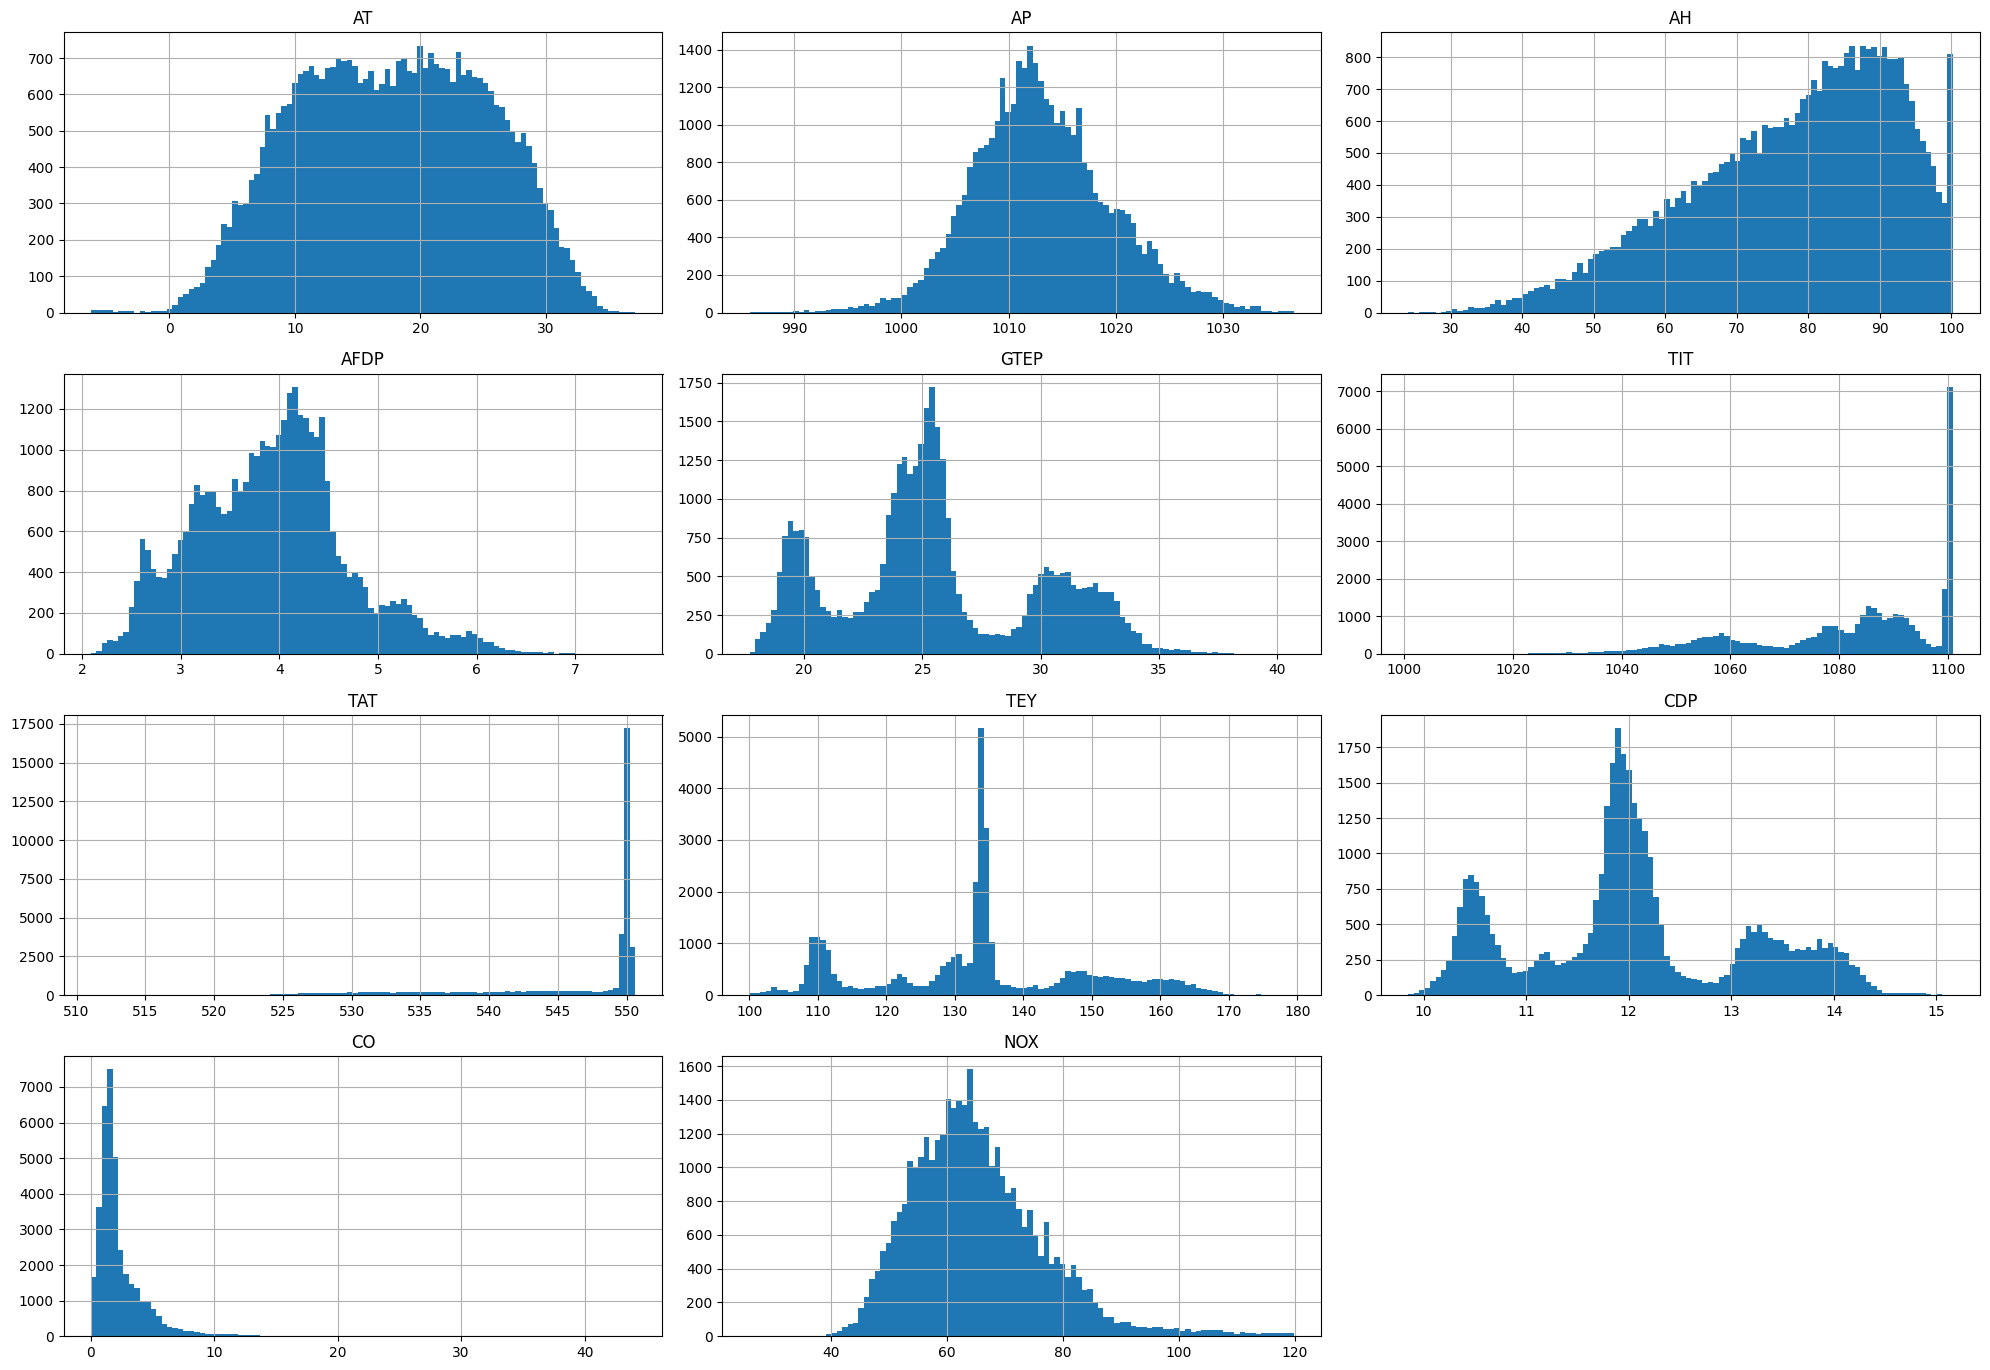

In [10]:
# Histograms
plt.figure(figsize=(20, 15))
plt.suptitle("Histograms of Features", fontsize=16)
data_exp.hist(bins=100, figsize=(20, 15))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- AFDP, GTEP, TEY, and CDP exhibit clear multimodal distributions. Investigating whether these correspond to different operating states, equipment settings, or external conditions would be critical.
- AH, TIT, and CO show clear skewness.
-  The sharp peak in TAT suggests limited variability or constant values.

##3.3. Correlations

In this section, we study the correlation between features.

###3.3.1. Correlation matrix


In [11]:
# Correlation Matrix
corr_matrix = data_exp.corr()
corr_matrix

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
AT,1.000000,-0.406601,-0.476291,0.251974,0.045851,0.183706,0.281869,-0.091152,0.015287,-0.174326,-0.558174
AP,-0.406601,1.000000,-0.015184,-0.040363,0.057533,-0.005390,-0.225601,0.118224,0.102636,0.067050,0.191938
AH,-0.476291,-0.015184,1.000000,-0.147840,-0.235153,-0.221809,0.022965,-0.137360,-0.196275,0.106586,0.164617
AFDP,0.251974,-0.040363,-0.147840,1.000000,0.678485,0.691292,-0.466882,0.665483,0.702568,-0.448425,-0.188247
GTEP,0.045851,0.057533,-0.235153,0.678485,1.000000,0.874234,-0.699703,0.964127,0.978470,-0.518909,-0.201630
TIT,0.183706,-0.005390,-0.221809,0.691292,0.874234,1.000000,-0.380862,0.910297,0.908469,-0.706275,-0.213865
TAT,0.281869,-0.225601,0.022965,-0.466882,-0.699703,-0.380862,1.000000,-0.682396,-0.706438,0.058353,-0.092791
TEY,-0.091152,0.118224,-0.137360,0.665483,0.964127,0.910297,-0.682396,1.000000,0.988778,-0.569813,-0.116127
CDP,0.015287,0.102636,-0.196275,0.702568,0.978470,0.908469,-0.706438,0.988778,1.000000,-0.551027,-0.171256
CO,-0.174326,0.067050,0.106586,-0.448425,-0.518909,-0.706275,0.058353,-0.569813,-0.551027,1.000000,0.340606


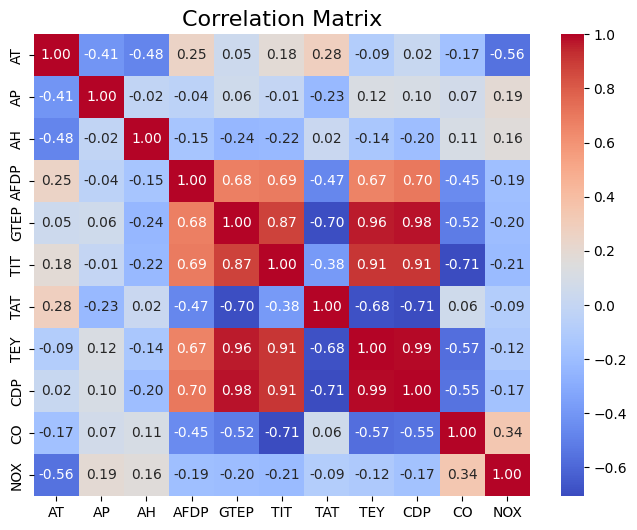

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Correlation Matrix", fontsize=16)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

###3.3.2. High correlation pairs

High correlation pairs:


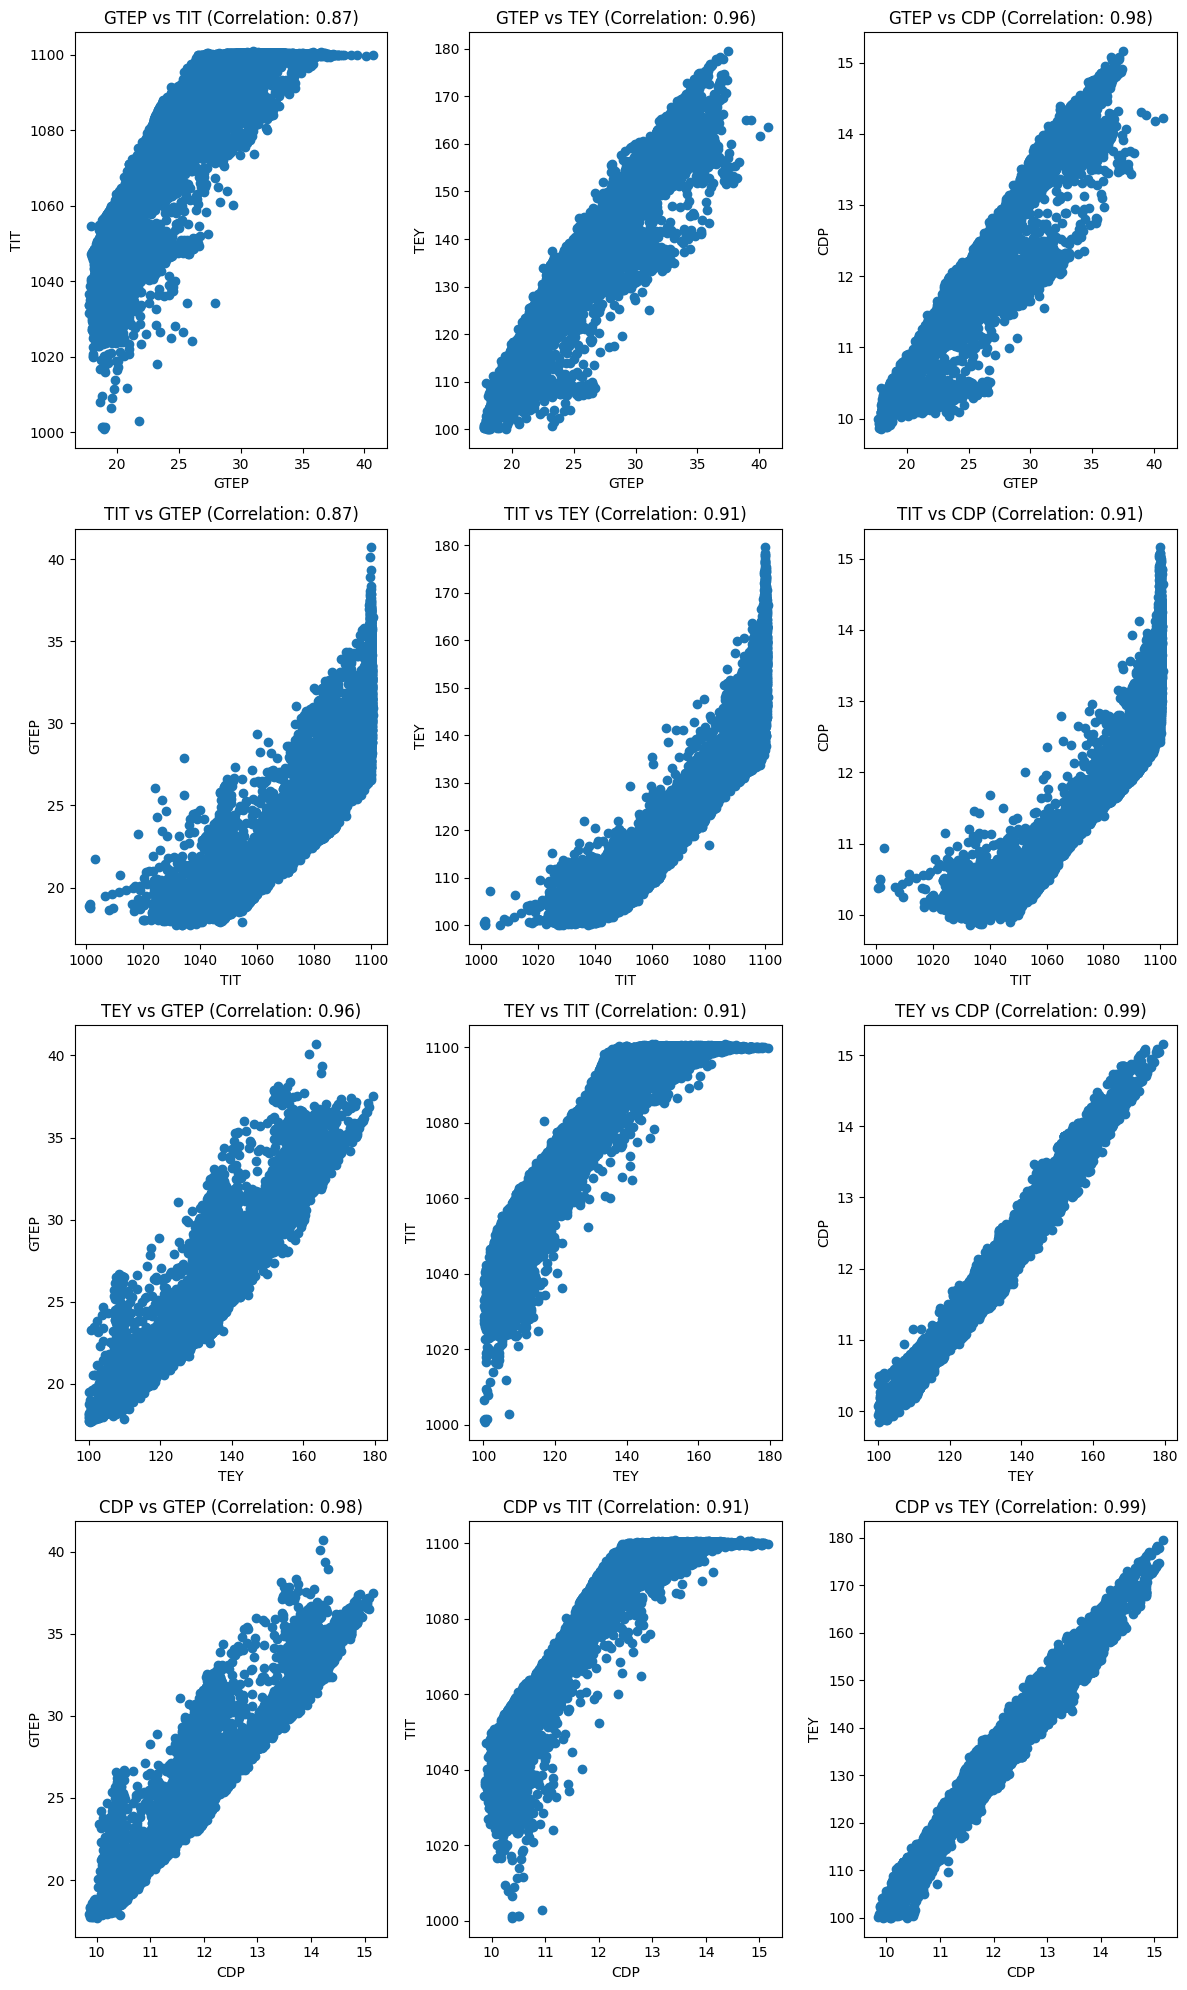

In [13]:
# Plot high correlation pairs
print("High correlation pairs:")

# Define high_corr_pairs based on the correlation matrix
high_corr_pairs = []
for col1 in corr_matrix.columns:
    for col2 in corr_matrix.columns:
        if col1 != col2 and abs(corr_matrix.loc[col1, col2]) > 0.85:
            high_corr_pairs.append((col1, col2))


n_pairs = len(high_corr_pairs)
n_cols = 3
n_rows = math.ceil(n_pairs / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5 * n_rows))

axes = axes.flatten()

for i, (col1, col2) in enumerate(high_corr_pairs):
    axes[i].scatter(df[col1], df[col2])
    axes[i].set_xlabel(col1)
    axes[i].set_ylabel(col2)
    axes[i].set_title(f'{col1} vs {col2} (Correlation: {corr_matrix.loc[col1, col2]:.2f})')


# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

## 3.4. Boxplots

<Axes: >

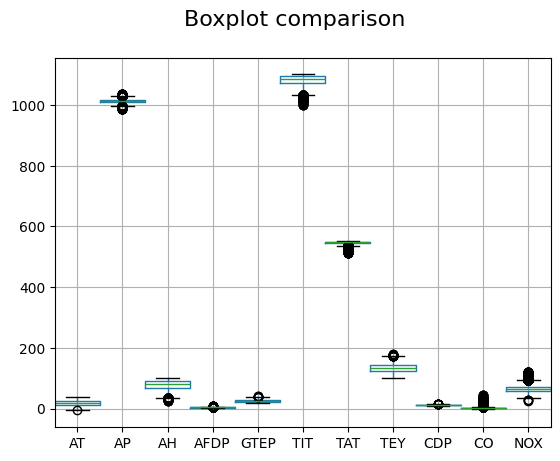

In [14]:
# Boxplots
plt.suptitle("Boxplot comparison", fontsize=16)
data_exp.boxplot(figsize = (10, 10), widths = 1)

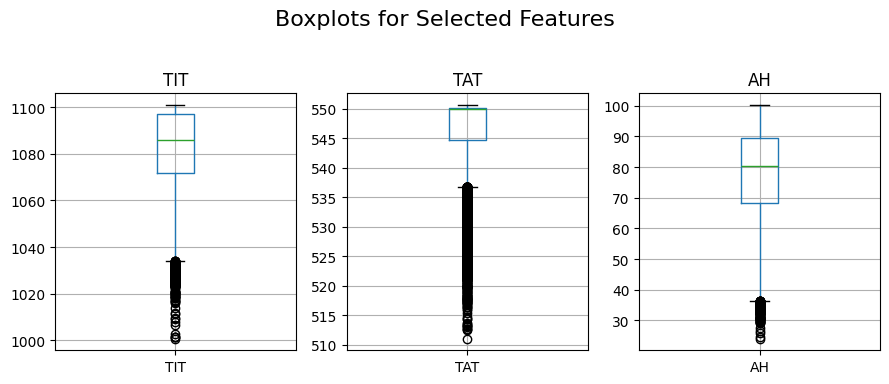

In [ ]:
#Boxplots selected features

plt.figure(figsize=(9, 4))
plt.suptitle("Boxplots for Selected Features", fontsize=16)

plt.subplot(1, 3, 1)
plt.title('TIT')
df.boxplot(column='TIT')

plt.subplot(1, 3, 2)
plt.title('TAT')
df.boxplot(column='TAT')

plt.subplot(1, 3, 3)
plt.title('AH')
df.boxplot(column='AH')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

##3.5. Target exploration

### 3.5.1. Description

In [ ]:
X = df.drop('TEY', axis=1)
y = df['TEY']

# Summary Statistics for TEY
print("Summary Statistics for TEY:")
print(y.describe())


### 3.5.2. Histogram

In [ ]:
#Distribution of TEY
plt.figure(figsize=(8, 6))
sns.histplot(y, kde=True, bins=30, color='skyblue')
plt.title("Distribution of Turbine Energy Yield (TEY)", fontsize=14)
plt.xlabel("TEY", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True)
plt.show()


The distribution of TEY shows a roughly multi-peaked character, mainly concentrated in the range of about 130, suggesting that the data may have more than one potential operational state.

### 3.5.3. Time series

In [ ]:
#Time Series Analysis of TEY
plt.figure(figsize=(10, 6))
plt.plot(range(len(y)), y, color='green')
plt.title("TEY Over Time", fontsize=14)
plt.xlabel("Time (Ordered Data)", fontsize=12)
plt.ylabel("TEY", fontsize=12)
plt.grid(True)
plt.show()

TEY fluctuates significantly in time, showing a tendency to change periodically. This may be related to different conditions of equipment operation, changes in the external environment, and other factors.

### 3.5.4. Feature correlation with target

In [ ]:
# Combine features and target for correlation matrix
data = X.copy()
data['TEY'] = y
corr_matrix = data.corr()

# Display correlations with TEY
print("\nCorrelations with TEY:")
print(corr_matrix["TEY"].sort_values(ascending=False))


High positive correlation: CDP, GTEP, TIT.

Moderately positive correlation: AFDP

Negative correlation: TAT, CO

Other characteristics such as NOX, AT, and AH are weakly correlated with TEY.

In [ ]:
# Scatterplots of top 3 correlated features with TEY
top_features = corr_matrix["TEY"].sort_values(ascending=False).head(4).index[1:]
n_features = len(top_features)
fig, axes = plt.subplots(1, n_features, figsize=(8, 6), sharey=True)  # 1 row, n_features columns

for i, feature in enumerate(top_features):
    sns.scatterplot(x=X[feature], y=y, ax=axes[i])
    axes[i].set_title(f"TEY vs {feature}", fontsize=14)
    axes[i].set_xlabel(feature, fontsize=12)
    axes[i].set_ylabel("TEY", fontsize=12)
    axes[i].grid(True)

plt.tight_layout()
plt.show()


Based on the correlation between features, it is seen that:
- Features like CDP and GTEP, with strong linear correlations, make regression models a good fit. If slight nonlinear relationships exist (TIT), algorithms like Random Forest or XGBoost will handle them well.
- Random Forest and XGBoost could quantify the importance of CDP, GTEP, and TIT, helping refine your model.

### 3.5.6. Feature importance

In [ ]:
#Feature Importance (Mutual Information)
importance = mutual_info_regression(X, y)
importance_scores = pd.Series(importance, index=X.columns).sort_values(ascending=False)

print("\nFeature Importance (Mutual Information):")
print(importance_scores)

In [ ]:
# Visualizing Feature Importance
plt.figure(figsize=(8, 5))
importance_scores.plot(kind='bar', color='purple')
plt.title("Feature Importance Based on Mutual Information", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.grid(True)
plt.show()

### 3.5.7. Boxplot

In [ ]:
# Outlier Detection (Boxplot for TEY)
plt.figure(figsize=(8, 6))
sns.boxplot(y, color='orange')
plt.title("Boxplot of TEY", fontsize=14)
plt.xlabel("TEY", fontsize=12)
plt.grid(True)
plt.show()

The distribution of TEY shows some high outliers (>170). These points may be samples from extreme running conditions or data noise and require further confirmation.
But as the number of outliers is relatively small, they may not have a significant impact on the overall distribution.

Since this dataset has fewer features, we chose to use the full dataset for our following training.

# 4. Unsupervised learning

## 4.1. Dimensionality reduction: PCA (Principal Component Analysis)


Here we are going to do the reduction of dimensions and the clustering for the dataset.

In [ ]:
# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_exp)

# Fit PCA
pca = PCA()
pca_data = pca.fit_transform(data_scaled)

# Explained variance ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(cumulative_variance)

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

# Determine the number of components that explain 95% of the variance
n_components = (cumulative_variance >= 0.95).argmax() + 1
print(f"Number of components that explain 95% of variance: {n_components}")

# Apply PCA with selected number of components
pca = PCA(n_components=n_components)
pca_data_reduced = pca.fit_transform(data_scaled)

In [ ]:
# Get PCA loadings (weights matrix)
loadings = pd.DataFrame(
    pca.components_,
    columns=data_exp.columns,  # Original feature names
    index=[f"PC{i+1}" for i in range(n_components)]  # Principal component names
)

# Display PCA loadings
print("PCA Loadings (Weights Matrix):")
print(loadings)

# Explained variance ratio for each principal component
explained_variance_ratio = pd.Series(
    pca.explained_variance_ratio_,
    index=[f"PC{i+1}" for i in range(n_components)]
)
print("\nExplained Variance Ratio:")
print(explained_variance_ratio)

## 4.2. K-Means Clustering


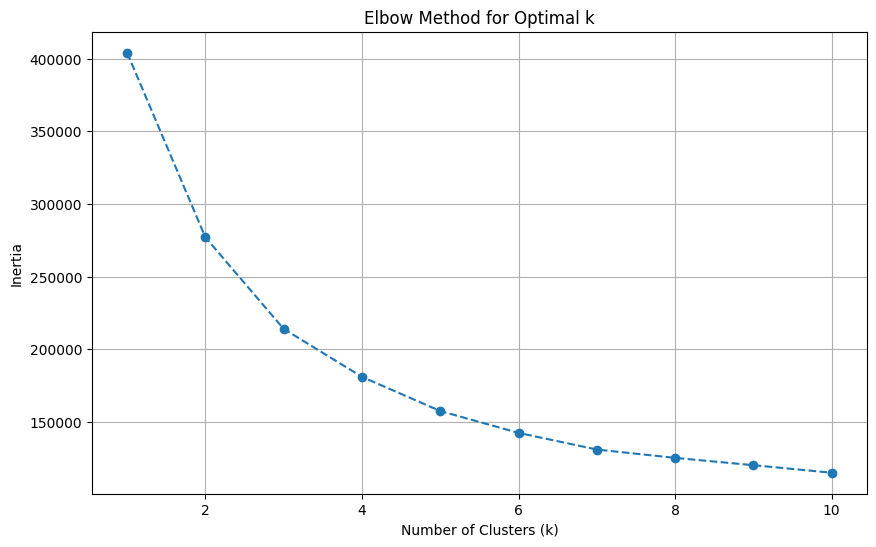

In [27]:
# Find the optimal number of clusters using the Elbow Method
inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

# Select optimal k (e.g., k=3 based on the Elbow Method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(data_scaled)

# Add cluster labels to the original data
data_exp['Cluster'] = cluster_labels

## 4.3 Result Comparison


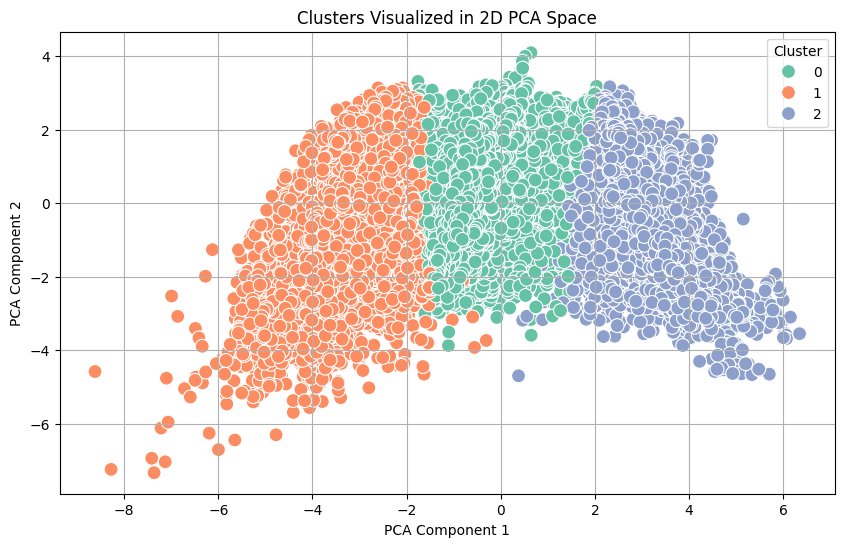

In [28]:
# Reduce to 2 components for visualization
pca_2d = PCA(n_components=2)
pca_data_2d = pca_2d.fit_transform(data_scaled)

# Create a scatter plot of clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=pca_data_2d[:, 0], y=pca_data_2d[:, 1], hue=cluster_labels, palette='Set2', s=100)
plt.title('Clusters Visualized in 2D PCA Space')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [29]:
#PCA and Clustering results
print("PCA Explained Variance Ratios:")
print(explained_variance)
print("\nCluster Centers (in standardized space):")
print(kmeans.cluster_centers_)

PCA Explained Variance Ratios:
[4.79989724e-01 1.99029340e-01 9.44752745e-02 7.63333376e-02
 6.26088194e-02 4.38807002e-02 2.36114385e-02 1.60131258e-02
 3.11433507e-03 7.50756802e-04 1.93147915e-04]

Cluster Centers (in standardized space):
[[ 1.00165828e-01 -5.75929836e-02 -5.83735953e-03 -4.05497803e-02
  -1.16135636e-01  1.93706850e-01  5.34844770e-01 -4.28259850e-02
  -8.69662002e-02 -2.83487922e-01 -9.18257308e-04]
 [-2.14033463e-01 -5.58283700e-04  2.89657306e-01 -9.86236472e-01
  -1.26391322e+00 -1.55183682e+00  3.17011593e-01 -1.35962121e+00
  -1.32226804e+00  1.16486442e+00  2.91659134e-01]
 [-1.15370557e-02  1.22153404e-01 -2.58344247e-01  1.00723335e+00
   1.42634151e+00  1.04103150e+00 -1.42578247e+00  1.36095246e+00
   1.41926809e+00 -4.89812124e-01 -2.70603614e-01]]


PCA:
 - Reduces model complexity and mitigates overfitting. Alleviates multicollinearity issues, improving model efficiency.
 - From the result, it is seen that using 6 principal components can preserve 95% of the variance, significantly reducing feature dimensions (from 12 to 6).
 - The first principal component contributes the most (45.88%), with the first two components explaining 65% of the total variance.


Clustering:
 - Cluster labels can be added as new features to the regression model, providing additional information about operational states. Models can be trained separately for each cluster to improve prediction accuracy.
 - From the result, the elbow method indicates that 𝑘 = 3 is the optimal number of clusters, with three distinct clusters visible in the PCA space.
 - The data points form 3 distinct clusters in the 2D PCA space, indicating that the data can indeed be divided into 3 groups by clustering. This validates the reasonableness of k=3

# 5. Supervised learning


Next we will train the dataset with different machine learning models，including the linear model, random forest, SVR, KNN and XGBoost, and then compare the results of the different models.

## 5.1 Data spliting

In [81]:
#### Train-test split (following the protocol: first 3 years for training, last 2 years for testing)
# Split as advised by the data frame owners
data_train = df[df['year'] <= 2013].copy()
data_test = df[df['year'] > 2013].copy()

# Prepare features and target variable
X_train = data_train.drop('TEY', axis=1)
X_test = data_test.drop('TEY', axis=1)

y_train = data_train['TEY']
y_test = data_test['TEY']

# Ensure X_train and y_train have the same index
X_train = X_train.reset_index(drop=True)  # Reset index of X_train
y_train = y_train.reset_index(drop=True)  # Reset index of y_train



## 5.2. Baseline model

In [82]:
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Make predictions and evaluate the baseline model
baseline_pred = baseline_model.predict(X_test)
baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
baseline_r2 = r2_score(y_test, baseline_pred)

print(f"Baseline Model RMSE: {baseline_rmse:.2f}")
print(f"Baseline Model R²: {baseline_r2:.2f}")


Baseline Model RMSE: 3.15
Baseline Model R²: 0.96


## 5.3. Pipelines preperation of advanced models

In [83]:
# Pipelines for advanced models (with feature scaling)
# Creating a pipeline for RandomForest, SVR, KNN, and XGBoost

# Random Forest Pipeline
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestRegressor(random_state=42))
])

# SVR Pipeline
svr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# KNN Pipeline
knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', xgb.XGBRegressor())
])


## 5.4. Model training

In [84]:
# Fit the models
rf_pipeline.fit(X_train, y_train)
svr_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Make predictions
rf_pred = rf_pipeline.predict(X_test)
svr_pred = svr_pipeline.predict(X_test)
knn_pred = knn_pipeline.predict(X_test)
xgb_pred = xgb_pipeline.predict(X_test)

# Evaluate the models
def evaluate_model(predictions, y_true):
    rmse = np.sqrt(mean_squared_error(y_true, predictions))
    r2 = r2_score(y_true, predictions)
    return rmse, r2

rf_rmse, rf_r2 = evaluate_model(rf_pred, y_test)
svr_rmse, svr_r2 = evaluate_model(svr_pred, y_test)
knn_rmse, knn_r2 = evaluate_model(knn_pred, y_test)
xgb_rmse, xgb_r2 = evaluate_model(xgb_pred, y_test)

# Display evaluation results
print(f"Random Forest RMSE: {rf_rmse:.2f}, R²: {rf_r2:.2f}")
print(f"SVR RMSE: {svr_rmse:.2f}, R²: {svr_r2:.2f}")
print(f"KNN RMSE: {knn_rmse:.2f}, R²: {knn_r2:.2f}")
print(f"XGBoost RMSE: {xgb_rmse:.2f}, R²: {xgb_r2:.2f}")


Random Forest RMSE: 1.82, R²: 0.99
SVR RMSE: 7.06, R²: 0.78
KNN RMSE: 3.66, R²: 0.94
XGBoost RMSE: 1.72, R²: 0.99


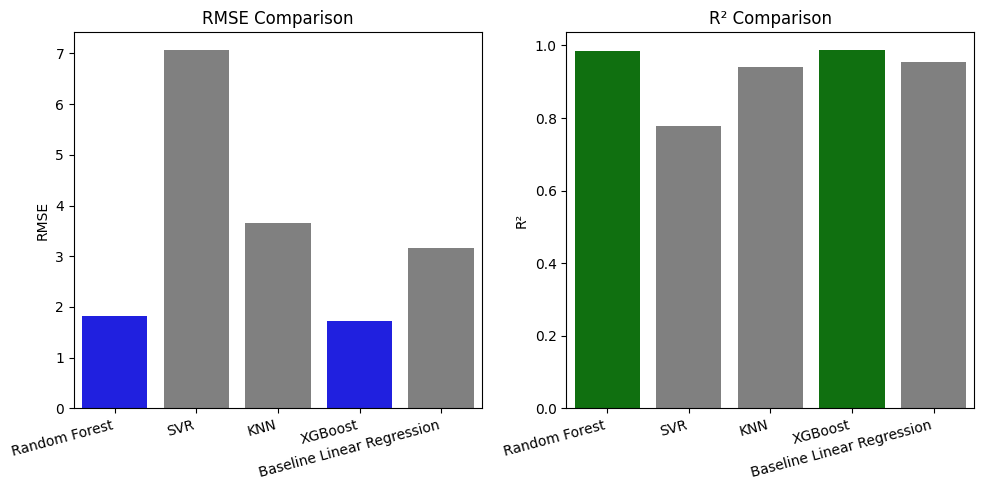

In [85]:
# Model Comparison
models = ['Random Forest', 'SVR', 'KNN', 'XGBoost', 'Baseline Linear Regression']
rmse_values = [rf_rmse, svr_rmse, knn_rmse, xgb_rmse, baseline_rmse]
r2_values = [rf_r2, svr_r2, knn_r2, xgb_r2, baseline_r2]

# Identify the two best models for RMSE and R²
best_rmse_indices = np.argsort(rmse_values)[:2]  # Top 2 lowest RMSE indices
best_r2_indices = np.argsort(r2_values)[-2:]    # Top 2 highest R² indices

rmse_colors = ['gray'] * len(models)
r2_colors = ['gray'] * len(models)

# Highlight the best models
for idx in best_rmse_indices:
    rmse_colors[idx] = 'blue'

for idx in best_r2_indices:
    r2_colors[idx] = 'green'

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=models, y=rmse_values, ax=ax[0], palette=rmse_colors)
ax[0].set_title('RMSE Comparison')
ax[0].set_ylabel('RMSE')
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=15, ha='right')  # Rotate x-axis labels

sns.barplot(x=models, y=r2_values, ax=ax[1], palette=r2_colors)
ax[1].set_title('R² Comparison')
ax[1].set_ylabel('R²')
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=15, ha='right')  # Rotate x-axis labels

plt.tight_layout()
plt.show()


In [86]:
performance_df = pd.DataFrame({
    'Model': models,
    'RMSE': rmse_values,
    'R²': r2_values
})

performance_df = performance_df.sort_values(by='RMSE', ignore_index=True)
performance_df.index = performance_df.index + 1

def highlight_rows(row):
    if row.name < 2 or row['Model'] == 'Random Forest':
        return ['font-weight: bold' for _ in row]
    else:
        return ['' for _ in row]

styled_df = performance_df.style.format({"RMSE": "{:.3f}", "R²": "{:.3f}"}).apply(highlight_rows, axis=1)
display(styled_df)

performance_df.to_csv("model_performance_summary_with_baseline.csv")

,Model,RMSE,R²
1,XGBoost,1.720,0.987
2,Random Forest,1.816,0.985
3,Baseline Linear Regression,3.154,0.956
4,KNN,3.659,0.940
5,SVR,7.060,0.778


Results Analyze:

1. Linear Regression
   - Linear regression performs relatively well but is outperformed by more sophisticated models. The high R²(0.96) indicates it explains a significant portion of the variance, but the RMSE value shows that it struggles to accurately predict the target variable.

2. Random Forest
   - Random forest demonstrates excellent performance, with low RMSE and high R², showing it can capture both nonlinear relationships and feature interactions effectively.


3. KNN
   - KNN shows weaker performance compared to other models, with relatively high RMSE and the lowest R².
   - This could result from sensitivity to local data distributions or suboptimal choice of K. It is less reliable when dealing with high-dimensional data or complex relationships.

4. XGBoost
   - XGBoost achieves the best performance, with the lowest RMSE and a high R², indicating strong predictive capabilities.
   - Its gradient boosting framework excels at handling complex feature relationships while maintaining high generalization power.
   - XGBoost slightly outperforms random forest, making it the top choice.

5. SVR
   - SVR performs poorly compared to all other models, with the highest RMSE and the lowest R² among the group.
   - This indicates that SVR struggles to capture the underlying data patterns, possibly due to inappropriate kernel choice, sensitivity to scaling, or lack of ability to handle the complexity of the data effectively.
   - While SVR can be powerful in specific contexts (e.g., small datasets, well-separated patterns), it does not appear to suit this dataset's characteristics.

## 5.5. Model tunning

In this part, we will complete the tuning of the random forest and XGBoost models。


In [87]:
# Hyperparameter grid for Random Forest
param_grid_rf = {
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 10],
    'rf__min_samples_leaf': [1, 5]
}

random_search_rf = RandomizedSearchCV(
    rf_pipeline,
    param_distributions=param_grid_rf,
    n_iter=5,  # Evaluating 5 random combinations
    cv=3,
    n_jobs=-1,
    verbose=2,
    scoring='neg_mean_squared_error'
)
random_search_rf.fit(X_train, y_train)

print("Best Hyperparameters (Random Search):")
print(random_search_rf.best_params_)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best Hyperparameters (Random Search):
{'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 1, 'rf__max_depth': 20}


In [88]:
# Hyperparameter grid for XGBoost
param_grid_xgb = {
    'xgb__learning_rate': [0.01, 0.1],
    'xgb__max_depth': [3, 5],
    'xgb__n_estimators': [50, 100],
    'xgb__subsample': [0.8, 0.9],
    'xgb__colsample_bytree': [0.7, 0.8]
}

# RandomizedSearchCV for XGBoost
random_search_xgb = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_grid_xgb,
    n_iter=10,  # Evaluate only 10 random combinations
    cv=3,  # Use 3 folds for cross-validation
    n_jobs=-1,  # Use all available cores for parallelization
    verbose=2,
    scoring='neg_mean_squared_error'
)

# Time the execution
start_time = time.time()
random_search_xgb.fit(X_train, y_train)
end_time = time.time()

# Print execution time
print(f"Execution time: {end_time - start_time} seconds")

# Print best hyperparameters
print("Best Hyperparameters (Random Search) for XGBoost:")
print(random_search_xgb.best_params_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Execution time: 8.675886154174805 seconds
Best Hyperparameters (Random Search) for XGBoost:
{'xgb__subsample': 0.8, 'xgb__n_estimators': 100, 'xgb__max_depth': 5, 'xgb__learning_rate': 0.1, 'xgb__colsample_bytree': 0.7}


## 5.6. Tuned model comparison

Best Random Forest RMSE: 1.81, R²: 0.99
Best XGBoost RMSE: 2.13, R²: 0.98


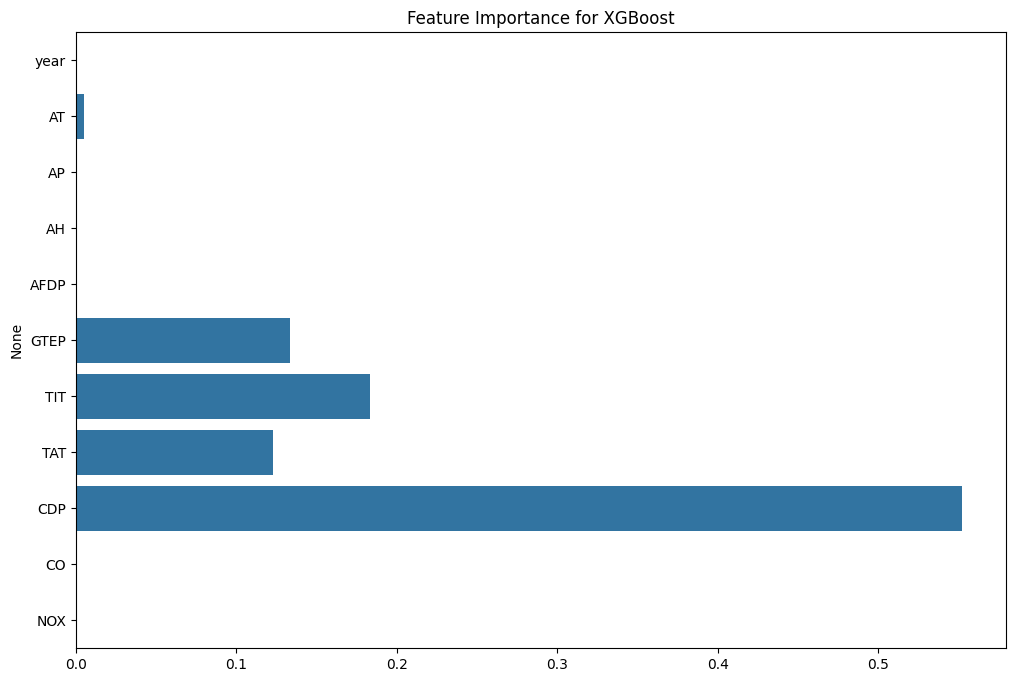

In [89]:
# Use the best models to make predictions
best_rf = random_search_rf.best_estimator_
best_xgb = random_search_xgb.best_estimator_

# Predictions with the best models
best_rf_pred = best_rf.predict(X_test)

best_xgb_pred = best_xgb.predict(X_test)

# Evaluate the best models
best_rf_rmse, best_rf_r2 = evaluate_model(best_rf_pred, y_test)

best_xgb_rmse, best_xgb_r2 = evaluate_model(best_xgb_pred, y_test)

print(f"Best Random Forest RMSE: {best_rf_rmse:.2f}, R²: {best_rf_r2:.2f}")

print(f"Best XGBoost RMSE: {best_xgb_rmse:.2f}, R²: {best_xgb_r2:.2f}")

# Feature Importance for XGBoost (most useful for tree-based models like Random Forest and XGBoost)
#importances = best_xgb.feature_importances_
importances = best_xgb.named_steps['xgb'].feature_importances_

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances, y=X.columns)
plt.title('Feature Importance for XGBoost')
plt.show()


# 6. Discusion of results

The results show that after hyperparameter tuning, the performance of the XGBoost model slightly declined:

Potential Reasons:
     - Hyperparameter tuning can sometimes result in overfitting to the training data or a suboptimal parameter set for the specific validation splits used during cross-validation.
     - The parameter grid used for tuning might not have included the optimal hyperparameter combinations that existed in the default settings.
     - RandomizedSearchCV evaluates a limited number of combinations. It’s possible the default settings happened to work better for the dataset than the combinations evaluated during tuning.
     - Maybe the training and test datasets have slight differences (e.g., different data distributions), a tuned model might generalize slightly worse than the default.

In fact, the difference in performance is relatively small. For many practical purposes, this might be considered negligible unless high precision is required. The default settings of XGBoost are often well-calibrated for general use, so the improvement after tuning may be minimal or even slightly negative in some cases.